In [73]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt

In [74]:
x = np.arange(0,8,1)
y = [1,-1,2,-0.8,3,2,-0.25,4]

In [75]:
line1 = np.ones_like(y)*3
line2 = 0.25*x
line3 = 4*x

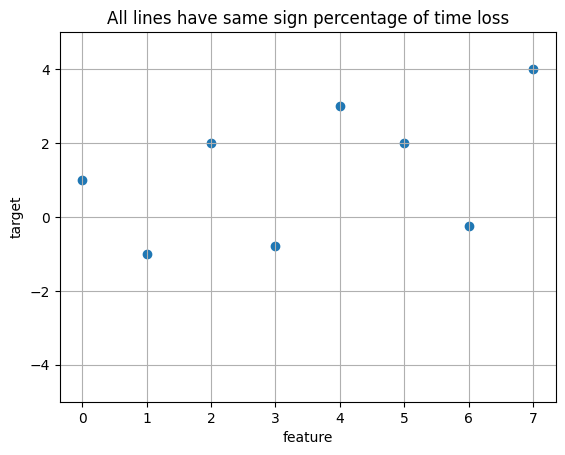

In [76]:
fig, ax = plt.subplots()
ax.scatter(x,y)

# ax.plot(x,line1, color = "red")
# ax.scatter(x,line1, color = "red")

# ax.plot(x, line2, color = "black")
# ax.scatter(x, line2, color = "black")

# ax.plot(x, line3, color = "green")
# ax.scatter(x, line3, color = "green")

ax.set_xlabel("feature")
ax.set_ylabel("target")
ax.set_title("Percentage of time above threshold")
ax.set_ylim(-5,5)
ax.grid()